# Computational Time Analysis

This script explores the time demands of model training and evaluation for the CML methods described in Model_Training_Assement.ipynb

## Load packages

In [26]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import  randint
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

Both the results data, and also the training/testing data so we can run some experiments below

In [27]:
# load results data

results_df = pd.read_csv('../data/results/CML_results.csv')

results_df.head()

,model,mean_r2,std_r2,mean_absolute_error,mean_squared_error,root_mean_squared_error,1 Run Time,K-Fold Time,Hyperparameter Time,best_params
0,LinearRegression,0.269172,0.155081,0.105245,0.019269,0.138814,0.037555,7.393572,NaN,NaN
1,RandomForestRegressor,0.256013,0.062276,0.110000,0.020508,0.143208,5.955610,5.326381,21.417977,NaN
2,HuberRegressor,0.331429,0.095918,0.110534,0.020068,0.141663,0.021428,0.066908,0.560758,NaN


In [28]:
# I'll need to start by loading the data

# set target (what are we trying to predict)
target = 'pwt_500hpa'

# set lists of coordinates and time ranges (pulled from Prepare_AI_Ready_Data.py)
coords = [[180,240,45,65],[130,250,20,75]]
times = [['1940-01-01','2023-12-31']]  # Ensure the time range is valid

# set PC option - seperate or combined
#PC_option = 'combined'
PC_option = 'seperate'

# select which of the list I want to load
coords_num = 1
times_num = 0

# pull the correct coordinate and time (as set above)
c = coords[coords_num]
t = times[times_num]

# read in PCs
if PC_option == 'combined':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_combined_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')
elif PC_option == 'seperate':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_seperate_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')

# Keep only columns that are target, contain "PC", or contain "month"
columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col or "month" in col]
data = raw_data[columns_to_keep]

# normalize all float columns to vary between 0 and 1, but ignore boolean columns
for col in data.columns:
    if data[col].dtype == 'float64':
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

data.head()

# Labels are the values we want to predict
labels = np.array(data[target])

# Remove the labels from the features
features = data.drop(columns=[target])

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# split the data into test/training sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 42)

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_2297/2009525425.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())


## Evaluate Training time (single run), K-fold time, and hyperparameter training time

Takeaways here are that:
- The linear models (Huber and linear regressors) are very very fast
- Hyperparameter tuning takes a while, particualrly for the random forest, but is not inhibitively long
- Something weird is going on with the k-fold time for the huber regressor. Not sure why - I even checked the code.
- The 1-run settup I have for the random forest was slow. Even slower than the k-fold analysis of this metric. It must have something to do with the setup. Let's figure out why...

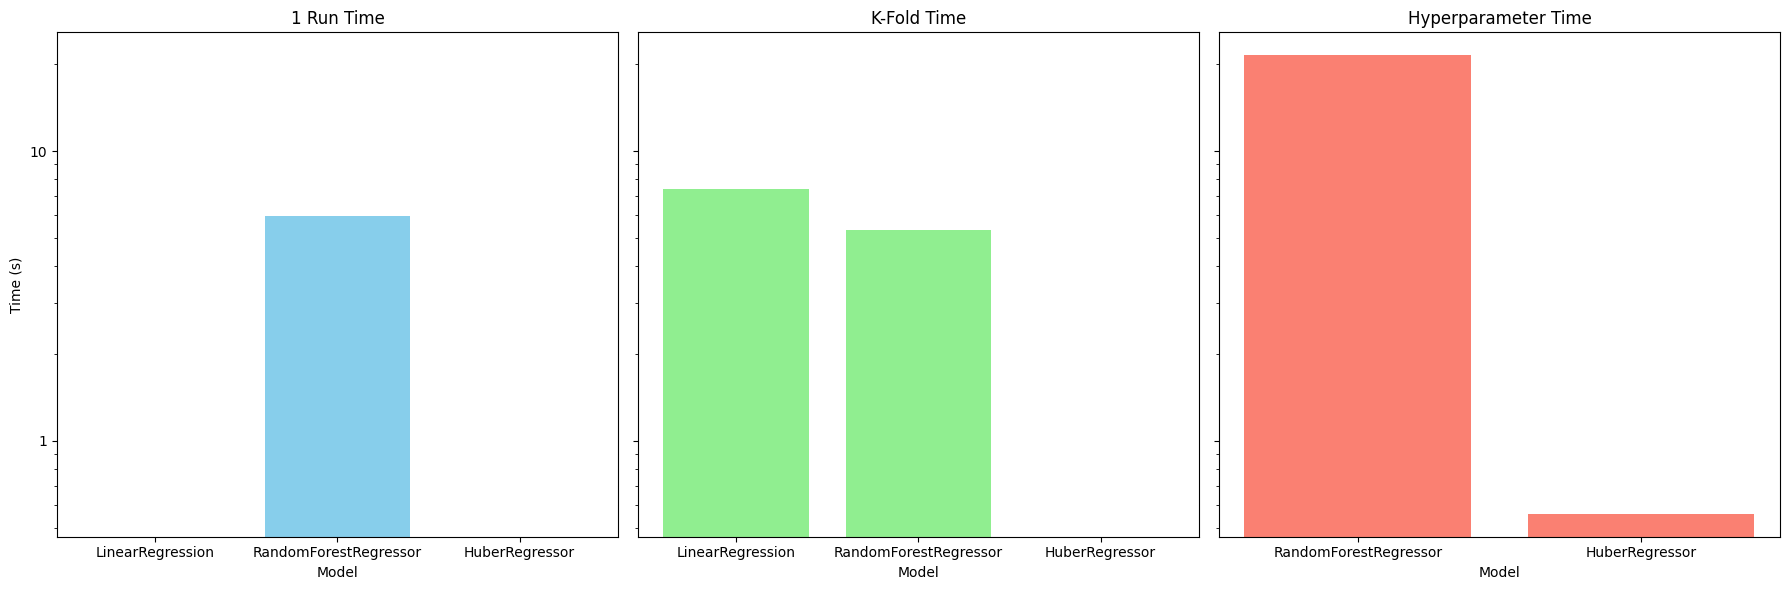

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot 1 Run Time
axes[0].bar(results_df['model'], results_df['1 Run Time'], color='skyblue')
axes[0].set_title('1 Run Time')
axes[0].set_ylabel('Time (s)')
axes[0].set_xlabel('Model')
axes[0].set_yscale('log')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:g}'))

# Plot K-Fold Time
axes[1].bar(results_df['model'], results_df['K-Fold Time'], color='lightgreen')
axes[1].set_title('K-Fold Time')
axes[1].set_xlabel('Model')
axes[1].set_yscale('log')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:g}'))

# Plot Hyperparameter Time
axes[2].bar(results_df['model'], results_df['Hyperparameter Time'], color='salmon')
axes[2].set_title('Hyperparameter Time')
axes[2].set_xlabel('Model')
axes[2].set_yscale('log')
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:g}'))

plt.tight_layout()
plt.show()

## What's going on with that Random Forest?

Below I run a little experiment to see why the random forest takes so long. it seems there's a pretty linear relationship between the number of estimators and the runtime. However, the preformance of the model does peak at around 1000 estimators, and declines at larger numbers. It does seem that there's a worthwhile tradeoff here to improve model preformance at the cost of runtime to reach this peak.

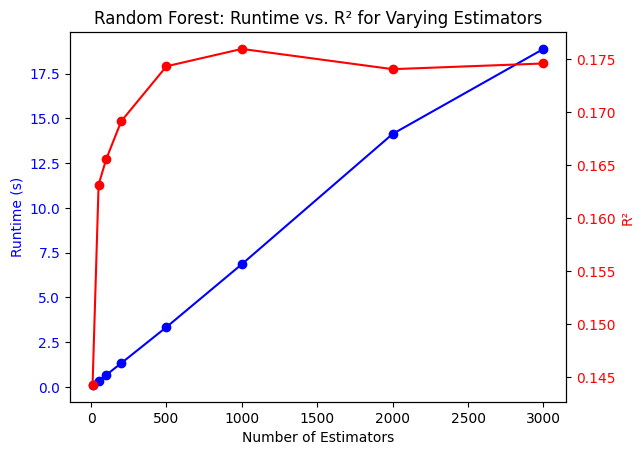

In [30]:
# Test different numbers of estimators
estimators = [10, 50, 100, 200, 500, 1000, 2000,3000]
runtimes = []
r2_values = []

for n in estimators:
    start_time = time.perf_counter()
    rf_test = RandomForestRegressor(n_estimators=n, random_state=42)
    rf_test.fit(train_features, train_labels)
    end_time = time.perf_counter()

    # Store runtime
    runtimes.append(end_time - start_time)

    # Calculate R^2
    test_preds = rf_test.predict(test_features)
    r2_values.append(r2_score(test_labels, test_preds))

# Plot with two y-axes
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(estimators, runtimes, color='blue', marker='o', label='Runtime')
ax_left.set_xlabel('Number of Estimators')
ax_left.set_ylabel('Runtime (s)', color='blue')
ax_left.tick_params(axis='y', labelcolor='blue')

ax_right.plot(estimators, r2_values, color='red', marker='o', label='R²')
ax_right.set_ylabel('R²', color='red')
ax_right.tick_params(axis='y', labelcolor='red')

plt.title('Random Forest: Runtime vs. R² for Varying Estimators')
plt.show()

# What drives Huber Regressor runtime?

I was able to mess with a couple of parameters in the Huber Regressor, and want to explore their impacts on runtime. My intuition is that epsilon and regression strength shouldn't impact the runtime much, as these parameters shouldn't change the total amount of calculations preformed. Indeed, this seems to have played out, as the runtime looks more like noise than a consistent trend.

However, I expected increasing the maximum iterations until convergence would result in longer runtimes. This doesn't seem to play out - the model apears to converge by 200 iterations, as the runtime doesn't increase past this point (and the fit doesn't improve).

/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Liam/anaconda3/envs/ess469_final/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


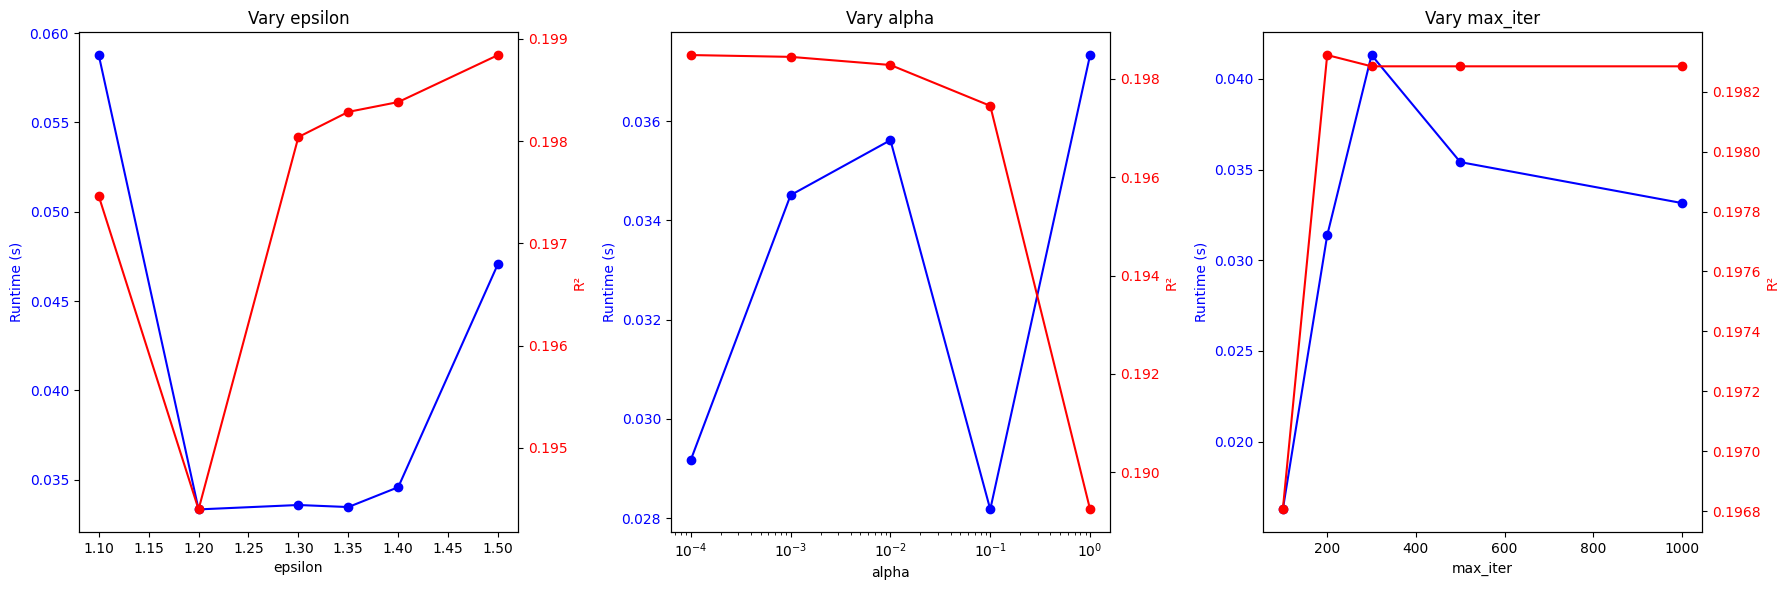

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) Vary epsilon
epsilon_list = [1.1, 1.2, 1.3, 1.35, 1.4, 1.5]
epsilon_times = []
epsilon_r2 = []
for e in epsilon_list:
    start = time.perf_counter()
    huber = HuberRegressor(alpha=0.01, epsilon=e, max_iter=300)
    huber.fit(train_features, train_labels)
    end = time.perf_counter()
    epsilon_times.append(end - start)
    preds = huber.predict(test_features)
    epsilon_r2.append(r2_score(test_labels, preds))

ax_left = axes[0]
ax_right = ax_left.twinx()
ax_left.plot(epsilon_list, epsilon_times, marker='o', color='blue', label='Runtime')
ax_right.plot(epsilon_list, epsilon_r2, marker='o', color='red', label='R²')
ax_left.set_title('Vary epsilon')
ax_left.set_xlabel('epsilon')
ax_left.set_ylabel('Runtime (s)', color='blue')
ax_right.set_ylabel('R²', color='red')
ax_left.tick_params(axis='y', labelcolor='blue')
ax_right.tick_params(axis='y', labelcolor='red')

# 2) Vary alpha
alpha_list = [0.0001, 0.001, 0.01, 0.1, 1.0]
alpha_times = []
alpha_r2 = []
for a in alpha_list:
    start = time.perf_counter()
    huber = HuberRegressor(alpha=a, epsilon=1.35, max_iter=300)
    huber.fit(train_features, train_labels)
    end = time.perf_counter()
    alpha_times.append(end - start)
    preds = huber.predict(test_features)
    alpha_r2.append(r2_score(test_labels, preds))

ax_left = axes[1]
ax_right = ax_left.twinx()
ax_left.plot(alpha_list, alpha_times, marker='o', color='blue', label='Runtime')
ax_right.plot(alpha_list, alpha_r2, marker='o', color='red', label='R²')
ax_left.set_title('Vary alpha')
ax_left.set_xlabel('alpha')
ax_left.set_ylabel('Runtime (s)', color='blue')
ax_right.set_ylabel('R²', color='red')
ax_left.tick_params(axis='y', labelcolor='blue')
ax_right.tick_params(axis='y', labelcolor='red')
ax_left.set_xscale('log')

# 3) Vary max_iter
maxiter_list = [100, 200, 300, 500, 1000]
maxiter_times = []
maxiter_r2 = []
for m in maxiter_list:
    start = time.perf_counter()
    huber = HuberRegressor(alpha=0.01, epsilon=1.35, max_iter=m)
    huber.fit(train_features, train_labels)
    end = time.perf_counter()
    maxiter_times.append(end - start)
    preds = huber.predict(test_features)
    maxiter_r2.append(r2_score(test_labels, preds))

ax_left = axes[2]
ax_right = ax_left.twinx()
ax_left.plot(maxiter_list, maxiter_times, marker='o', color='blue', label='Runtime')
ax_right.plot(maxiter_list, maxiter_r2, marker='o', color='red', label='R²')
ax_left.set_title('Vary max_iter')
ax_left.set_xlabel('max_iter')
ax_left.set_ylabel('Runtime (s)', color='blue')
ax_right.set_ylabel('R²', color='red')
ax_left.tick_params(axis='y', labelcolor='blue')
ax_right.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()
